In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import pandas as pd
import numpy as np
import scipy.misc
import scipy.io
import matplotlib as mtl
import matplotlib.pyplot as plt
import tensorflow.keras.applications.vgg19 as vgg19
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.image as image
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d teksab/imagenetvggverydeep19mat

 98% 502M/510M [00:15<00:00, 42.8MB/s]
100% 510M/510M [00:15<00:00, 34.7MB/s]


In [ ]:
! unzip imagenetvggverydeep19mat.zip -d /content/sample_data

Archive:  imagenetvggverydeep19mat.zip
  inflating: /content/sample_data/imagenet-vgg-verydeep-19.mat  


In [ ]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

In [ ]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [ ]:
model = load_vgg_model("/content/sample_data/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

In [ ]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

(1, 300, 400, 3)
(300, 400, 3)


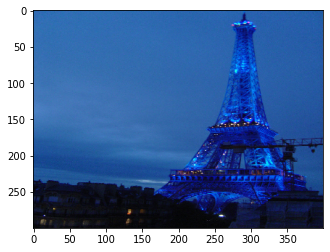

In [ ]:
content_image = image.load_img("/content/drive/My Drive/dataset/eifel.jpg",target_size=(300,400,3))
content_image=np.reshape(np.array(content_image),(1,300,400,3))
print(content_image.shape)
print(content_image[0].shape)
plt.imshow(content_image[0])

In [ ]:
def compute_content_cost(a_C,a_G):
  m,n_H,n_W,n_C=a_G.get_shape().as_list()
  a_C_unrolled=tf.transpose(tf.reshape(a_C,[n_H*n_W,n_C]))
  a_G_unrolled=tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))
  J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
  return J_content

In [ ]:
tf.disable_v2_behavior()
tf.compat.v1.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 7.6410217


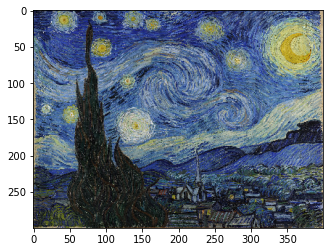

In [ ]:
style_image=image.load_img("/content/drive/My Drive/dataset/paint.jpg",target_size=(300,400,3))
style_image=np.reshape(np.array(style_image),(1,300,400,3))
plt.imshow(style_image[0])

In [ ]:
def gram_matrix(A):
  GA=tf.matmul(A,tf.transpose(A))
  return GA

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 15.615462  12.248833 -29.87157 ]
 [ 12.248833  10.877856 -19.879116]
 [-29.87157  -19.879116  67.08007 ]]


In [ ]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, ([n_H*n_W, n_C])))
    a_G = tf.transpose(tf.reshape(a_G, ([n_H*n_W, n_C])))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1./(4*n_C**2 *(n_H*n_W)**2)*tf.reduce_sum(tf.pow((GS - GG), 2))
    
    ### END CODE HERE ###
    
    return J_style_layer

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 2.284926


In [ ]:
def compute_style_cost(model,style_layers):
  J_style=0
  for layer_name,coeff in style_layers:
    out=model[layer_name]
    a_S=sess.run(out)
    a_G=out
    J_style_layer=compute_layer_style_cost(a_S,a_G)
    J_style=J_style+(coeff*J_style_layer)
  return J_style

In [ ]:

def compute_total_cost(J_content,J_style,alpha=90,beta=40):
  J=alpha*J_content+beta*J_style
  return J

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = compute_total_cost(J_content, J_style)
    print("J = " + str(J))

J = 178.43695662920825


In [ ]:
tf.reset_default_graph()
sess=tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1,300, 400, 3)).astype('float32')

    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + np.array(content_image) * (1 - noise_ratio)
    
    return input_image


In [ ]:
def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image

In [ ]:
content_image=reshape_and_normalize_image(np.asarray(content_image))
style_image=reshape_and_normalize_image(np.asarray(style_image))

In [ ]:
content_image=np.reshape(content_image,(1,300,400,3))
style_image=np.reshape(style_image,(1,300,400,3))
print(content_image.shape,style_image.shape)

(1, 300, 400, 3) (1, 300, 400, 3)


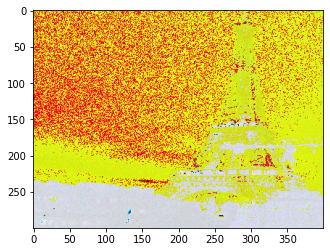

In [ ]:
generated_image=generate_noise_image(content_image)
plt.imshow(generated_image[0].astype('uint8'))

In [ ]:
model = load_vgg_model("/content/sample_data/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable_1:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_24:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 

In [ ]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [ ]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [ ]:
J=compute_total_cost(J_content,J_style,alpha=10,beta=40)

In [ ]:
optimizer=tf.train.AdamOptimizer(2)
train_step=optimizer.minimize(J)

In [ ]:
import imageio
# imageio.imwrite('filename.jpg', array)

def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path, image)

In [ ]:
def model_nn(sess,input_img,num_iterations=200):
  sess.run(tf.global_variables_initializer())
  sess.run(model["input"].assign(input_img))
  for i in range(num_iterations):
    sess.run(train_step)
    generated_image=sess.run(model["input"])
    # print(i,i%20)
    if i%20 == 0:
      Jt, Jc, Js = sess.run([J, J_content, J_style])
      print("Iteration " + str(i) + " :")
      print("total cost = " + str(Jt))
      print("content cost = " + str(Jc))
      print("style cost = " + str(Js))
      # image.save_img("output/"+str(i)+".png",generated_image)
    save_image("/content/sample_data/generated_image.jpg",generated_image)
  return generated_image

In [ ]:
a=model_nn(sess,generated_image,200)

Iteration 0 :
total cost = 6355558400.0
content cost = 11340.969
style cost = 158886110.0
Iteration 20 :
total cost = 433704860.0
content cost = 18755.246
style cost = 10837933.0
Iteration 40 :
total cost = 156041730.0
content cost = 20527.225
style cost = 3895911.0
Iteration 60 :
total cost = 95429720.0
content cost = 21026.959
style cost = 2380486.2
Iteration 80 :
total cost = 67552280.0
content cost = 21319.223
style cost = 1683477.2
Iteration 100 :
total cost = 51368024.0
content cost = 21502.26
style cost = 1278825.0
Iteration 120 :
total cost = 41059630.0
content cost = 21666.266
style cost = 1021074.2
Iteration 140 :
total cost = 34171244.0
content cost = 21802.164
style cost = 848830.56
Iteration 160 :
total cost = 29344650.0
content cost = 21926.877
style cost = 728134.56
Iteration 180 :
total cost = 25790578.0
content cost = 22032.209
style cost = 639256.4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


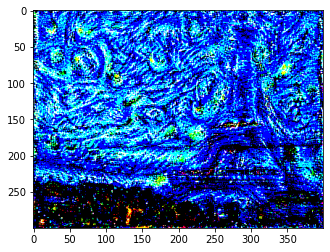

In [ ]:
plt.imshow(a[0])